In [1]:
# Import libraries
import os
import re
import io
import sys
import pandas as pd
import numpy as np
import pickle
import torch
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Read data
minutes = pd.read_pickle('../data/data-gen/sent_minutes.p')
seps    = pd.read_pickle('../data/data-gen/sent_seps.p')
beigeb  = pd.read_pickle('../data/data-gen/sent_beigebook.p')
movies  = pd.read_pickle('../data/data-gen/sent_movies.p')

In [3]:
print(minutes.shape)
minutes.head()

(4389, 3)


,doc_id,sentence_id,text
0,20071031,1,conjunction fomc meeting october meeting parti...
1,20071031,2,projec tions summary economic projections atta...
2,20071031,3,discussion economic outlook situa tion project...
3,20071031,4,conditions financial markets improved septembe...
4,20071031,5,easing monetary policy participants expected e...


In [4]:
print(seps.shape)
seps.head()

(4520, 3)


,doc_id,sentence_id,text
0,20071031,1,summary economic projections conjunction octob...
1,20071031,2,projections based information con clusion octo...
2,20071031,3,monetary policy defined future policy foster o...
3,20071031,4,projections summarized table chart suggest fom...
4,20071031,5,ahead output projected expand pace close run t...


In [5]:
print(beigeb.shape)
beigeb.head()

(6345, 3)


,doc_id,sentence_id,text
0,20071031,1,beige book national summary october anecdotal ...
1,20071031,2,growth similar observed beige book districts a...
2,20071031,3,louis
3,20071031,4,economy grew slower rate districts cleveland d...
4,20071031,5,expansion variously characterized moderate mod...


In [6]:
print(movies.shape)
movies.head()

(2080, 3)


,doc_id,sentence_id,text
0,20071031,1,holidate
1,20071031,2,emma roberts stars single girl arranges standi...
2,20071031,3,craft legacy
3,20071031,4,witchy foursome picks brooms follow craft zoe ...
4,20071031,5,constitution means


In [7]:
# Load big roBERTa model and use the GPU
model = SentenceTransformer('c:/Users/d1rxh02/Downloads/rfolder/SentenceTransformers/roberta-large-nli-stsb-means-tokens', device = 'cuda' )

In [8]:
# example
sentences1 = minutes[minutes.doc_id=='20080130'].text
sentences2 = seps[seps.doc_id=='20080130'].text
print(sentences1.shape)
print(sentences2.shape)

(67,)
(56,)


In [9]:
# Have to reset the index or an error pops up
sentences1 = sentences1.reset_index()
sentences2 = sentences2.reset_index()

In [10]:
# Compute embeddings for both lists
# The result is a list of vectors, one for each sentence
embeddings1 = model.encode(sentences1.text, convert_to_tensor=True)
embeddings2 = model.encode(sentences2.text, convert_to_tensor=True)

In [11]:
type(embeddings1)

torch.Tensor

In [12]:
print(embeddings1.shape)
print(embeddings2.shape)

torch.Size([67, 1024])
torch.Size([56, 1024])


In [13]:
# Compute cosine-similarities
# This calculates the similarities between all pairs of vectors
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

In [14]:
cosine_scores.shape

torch.Size([67, 56])

In [15]:
# This is 2-dim array of cross-pairs, not what we want
cosine_scores

tensor([[0.9024, 0.7340, 0.5987,  ..., 0.4959, 0.3602, 0.5570],
        [0.3936, 0.4746, 0.4435,  ..., 0.4256, 0.3156, 0.4018],
        [0.5028, 0.5167, 0.2500,  ..., 0.3385, 0.3395, 0.2817],
        ...,
        [0.5282, 0.4829, 0.5473,  ..., 0.5658, 0.5898, 0.5626],
        [0.2224, 0.3900, 0.4823,  ..., 0.4953, 0.3920, 0.3966],
        [0.4481, 0.4789, 0.4873,  ..., 0.5254, 0.4351, 0.4270]],
       device='cuda:0')

In [16]:
# Calculate average of embeddings
# This provides one vector per document
# Alternatively, can calculate sum
embedding_1 = torch.mean(embeddings1, dim = 0)
embedding_2 = torch.mean(embeddings2, dim = 0)

In [17]:
# Calculate cosine similarity
# This returns a scalar measure
cos_sim = torch.nn.CosineSimilarity(dim = 0)
result = cos_sim(embedding_1, embedding_2)
print(result)

tensor(0.8456, device='cuda:0')


In [32]:
# Define main procedure to calculate 3 different measures of document similarity
# between pairs among 4 documents

def calc_simil_docs(doc1, doc2, doc3, doc4):
    # Calculates similarity between pairs of documents
    # Each document is a series of sentences
           
    # Calculate embeddings of all sentences at once, these are one vector per sentence
    embeddings1 = model.encode(doc1.reset_index(drop = True), convert_to_tensor=True)
    embeddings2 = model.encode(doc2.reset_index(drop = True), convert_to_tensor=True)
    embeddings3 = model.encode(doc3.reset_index(drop = True), convert_to_tensor=True)
    embeddings4 = model.encode(doc4.reset_index(drop = True), convert_to_tensor=True)
        
    # Calculate mean of embeddings, this is now a vector per document
    embedding_1 = torch.mean(embeddings1, dim = 0)
    embedding_2 = torch.mean(embeddings2, dim = 0)
    embedding_3 = torch.mean(embeddings3, dim = 0)
    embedding_4 = torch.mean(embeddings4, dim = 0)

    # Calculate different measures of similarity
    
    # 1. Calculate cosine similarity between two tensors
    cos_sim = torch.nn.CosineSimilarity(dim = 0)
    cosine_similarity_1_2 = cos_sim(embedding_1, embedding_2)
    cosine_similarity_1_3 = cos_sim(embedding_1, embedding_3)
    cosine_similarity_1_4 = cos_sim(embedding_1, embedding_4)
    cosine_similarity_2_3 = cos_sim(embedding_2, embedding_3)
    cosine_similarity_2_4 = cos_sim(embedding_2, embedding_4)
    cosine_similarity_3_4 = cos_sim(embedding_3, embedding_4)
    
    # 2. Calculate Euclidean distance similariy = (1 - distance)
    # Calculate norm
    norm_embedding_1 = torch.linalg.norm(embedding_1)
    norm_embedding_2 = torch.linalg.norm(embedding_2)
    norm_embedding_3 = torch.linalg.norm(embedding_3)
    norm_embedding_4 = torch.linalg.norm(embedding_4)

    # Calculate Euclidean distance, normalize distance
    euclidean_dist_1_2 = torch.dist(embedding_1, embedding_2).div( norm_embedding_1 + norm_embedding_2 )
    euclidean_dist_1_3 = torch.dist(embedding_1, embedding_3).div( norm_embedding_1 + norm_embedding_3 )
    euclidean_dist_1_4 = torch.dist(embedding_1, embedding_4).div( norm_embedding_1 + norm_embedding_4 )
    euclidean_dist_2_3 = torch.dist(embedding_2, embedding_3).div( norm_embedding_2 + norm_embedding_3 )
    euclidean_dist_2_4 = torch.dist(embedding_2, embedding_4).div( norm_embedding_2 + norm_embedding_4 )
    euclidean_dist_3_4 = torch.dist(embedding_3, embedding_4).div( norm_embedding_3 + norm_embedding_4 )
    
    # Calculate Euclidean similarity
    euclidean_similarity_1_2 = 1 - euclidean_dist_1_2
    euclidean_similarity_1_3 = 1 - euclidean_dist_1_3
    euclidean_similarity_1_4 = 1 - euclidean_dist_1_4
    euclidean_similarity_2_3 = 1 - euclidean_dist_2_3
    euclidean_similarity_2_4 = 1 - euclidean_dist_2_4
    euclidean_similarity_3_4 = 1 - euclidean_dist_3_4
    
    # 3. Calculate Pearson correlation
    # Transform tensors into numpy arrays and calculate correlation 
    emb_np_1 = embedding_1.cpu().numpy()
    emb_np_2 = embedding_2.cpu().numpy()
    emb_np_3 = embedding_3.cpu().numpy()
    emb_np_4 = embedding_4.cpu().numpy()
    # Calculate correlatoin 
    pearson_correlation_1_2 = scipy.stats.pearsonr(emb_np_1, emb_np_2)[0]
    pearson_correlation_1_3 = scipy.stats.pearsonr(emb_np_1, emb_np_3)[0]
    pearson_correlation_1_4 = scipy.stats.pearsonr(emb_np_1, emb_np_4)[0]
    pearson_correlation_2_3 = scipy.stats.pearsonr(emb_np_2, emb_np_3)[0]
    pearson_correlation_2_4 = scipy.stats.pearsonr(emb_np_2, emb_np_4)[0]
    pearson_correlation_3_4 = scipy.stats.pearsonr(emb_np_3, emb_np_4)[0]
    
    # Collect results, bringing to cpu from gpu as numpy arrays
    cosine_similarity     = torch.stack([cosine_similarity_1_2, 
                                         cosine_similarity_1_3, 
                                         cosine_similarity_1_4, 
                                         cosine_similarity_2_3, 
                                         cosine_similarity_2_4, 
                                         cosine_similarity_3_4]).cpu().numpy()
    euclidean_similarity =  torch.stack([euclidean_similarity_1_2, 
                                         euclidean_similarity_1_3, 
                                         euclidean_similarity_1_4, 
                                         euclidean_similarity_2_3, 
                                         euclidean_similarity_2_4, 
                                         euclidean_similarity_3_4]).cpu().numpy()
    pearson_correlation =   np.array([pearson_correlation_1_2, 
                                     pearson_correlation_1_3, 
                                     pearson_correlation_1_4, 
                                     pearson_correlation_2_3, 
                                     pearson_correlation_2_4, 
                                     pearson_correlation_3_4])
        
    return cosine_similarity, euclidean_similarity, pearson_correlation

In [33]:
# Calculate similarites between pairs of documents
simil_results    = []
for docid in minutes.doc_id.unique():
    print('Now processing doc_id=', docid,' ...')
    sent_min = minutes[minutes.doc_id == docid].text
    sent_sep = seps[seps.doc_id == docid].text
    sent_beb = beigeb[beigeb.doc_id == docid].text
    sent_mov = movies[movies.doc_id == docid].text
    simil_res = calc_simil_docs(sent_min, sent_sep, sent_beb, sent_mov)
    simil_results.append(simil_res)

Now processing doc_id= 20071031  ...
Now processing doc_id= 20080130  ...
Now processing doc_id= 20080430  ...
Now processing doc_id= 20080625  ...
Now processing doc_id= 20081029  ...
Now processing doc_id= 20090128  ...
Now processing doc_id= 20090429  ...
Now processing doc_id= 20090624  ...
Now processing doc_id= 20091104  ...
Now processing doc_id= 20100127  ...
Now processing doc_id= 20100428  ...
Now processing doc_id= 20100623  ...
Now processing doc_id= 20101103  ...
Now processing doc_id= 20110126  ...
Now processing doc_id= 20110427  ...
Now processing doc_id= 20110622  ...
Now processing doc_id= 20111102  ...
Now processing doc_id= 20120125  ...
Now processing doc_id= 20120425  ...
Now processing doc_id= 20120620  ...
Now processing doc_id= 20120913  ...
Now processing doc_id= 20121212  ...
Now processing doc_id= 20130320  ...
Now processing doc_id= 20130619  ...
Now processing doc_id= 20130918  ...
Now processing doc_id= 20131218  ...
Now processing doc_id= 20140319  ...
N

In [36]:
# The result is a nested list
simil_results[0][1]

array([0.7838011 , 0.73341656, 0.41247624, 0.6781072 , 0.4306752 ,
       0.48225206], dtype=float32)

In [37]:
# Separate lists to form pandas data frames
cosine_similarity = []
euclid_similarity = []
pearsn_similarity = []
for list in simil_results:
    cosine_similarity.append(list[0])
    euclid_similarity.append(list[1])
    pearsn_similarity.append(list[2])

In [38]:
dates = minutes.doc_id.unique()

In [39]:
df_cosine = pd.DataFrame(np.vstack(cosine_similarity), 
                         columns =['cosine_min_sep', 'cosine_min_beb', 'cosine_min_mov',
                                   'cosine_sep_beb', 'cosine_sep_mov', 'cosine_beb_mov'])
df_cosine.insert(loc = 0, column = 'doc_id', value = dates)
df_euclid = pd.DataFrame(np.vstack(euclid_similarity), 
                         columns =['euclid_min_sep', 'euclid_min_beb', 'euclid_min_mov',
                                   'euclid_sep_beb', 'euclid_sep_mov', 'euclid_beb_mov'])
df_euclid.insert(loc = 0, column = 'doc_id', value = dates)
df_pearsn = pd.DataFrame(np.vstack(cosine_similarity), 
                         columns =['pearsn_min_sep', 'pearsn_min_beb', 'pearsn_min_mov',
                                   'pearsn_sep_beb', 'pearsn_sep_mov', 'pearsn_beb_mov'])
df_pearsn.insert(loc = 0, column = 'doc_id', value = dates)

In [40]:
df_cosine.head()

,doc_id,cosine_min_sep,cosine_min_beb,cosine_min_mov,cosine_sep_beb,cosine_sep_mov,cosine_beb_mov
0,20071031,0.906957,0.879239,0.389516,0.807933,0.424077,0.491718
1,20080130,0.845563,0.804725,0.360337,0.713483,0.435084,0.523298
2,20080430,0.910424,0.781343,0.373560,0.732235,0.433129,0.500008
3,20080625,0.904183,0.711171,0.364949,0.672773,0.405577,0.518066
4,20081029,0.867250,0.810873,0.355808,0.702529,0.344487,0.468778


In [41]:
df_euclid.head()

,doc_id,euclid_min_sep,euclid_min_beb,euclid_min_mov,euclid_sep_beb,euclid_sep_mov,euclid_beb_mov
0,20071031,0.783801,0.733417,0.412476,0.678107,0.430675,0.482252
1,20080130,0.722118,0.673266,0.401457,0.610204,0.431635,0.496623
2,20080430,0.788330,0.660326,0.410247,0.625351,0.433619,0.484544
3,20080625,0.781073,0.609077,0.405189,0.584536,0.420344,0.495325
4,20081029,0.742359,0.674018,0.395874,0.600823,0.392040,0.470482


In [42]:
df_pearsn.head()

,doc_id,pearsn_min_sep,pearsn_min_beb,pearsn_min_mov,pearsn_sep_beb,pearsn_sep_mov,pearsn_beb_mov
0,20071031,0.906957,0.879239,0.389516,0.807933,0.424077,0.491718
1,20080130,0.845563,0.804725,0.360337,0.713483,0.435084,0.523298
2,20080430,0.910424,0.781343,0.373560,0.732235,0.433129,0.500008
3,20080625,0.904183,0.711171,0.364949,0.672773,0.405577,0.518066
4,20081029,0.867250,0.810873,0.355808,0.702529,0.344487,0.468778


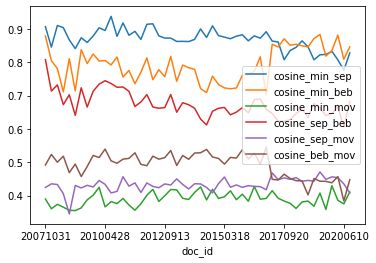

In [43]:
df_cosine.plot(x = "doc_id")
plt.show()

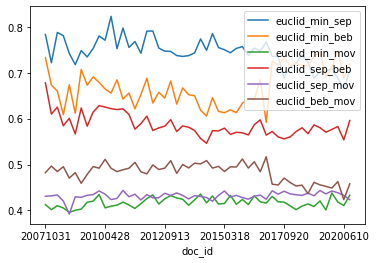

In [44]:
df_euclid.plot(x = "doc_id")
plt.show()

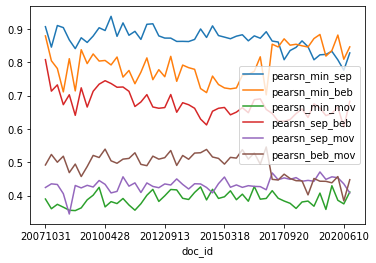

In [45]:
df_pearsn.plot(x = "doc_id")
plt.show()

In [46]:
# Write data for R
df_cosine.to_pickle('../data/data-gen/df_cosine.p')
df_euclid.to_pickle('../data/data-gen/df_euclid.p')
df_pearsn.to_pickle('../data/data-gen/df_pearsn.p')